In [2]:
from sklearn.datasets import load_wine
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from scipy import stats
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings("ignore")

In [87]:
class SplitData:
    def __init__(self, n_estimators, type_split, random_size=None):
        self.dataset_indexes = []
        self.n_estimators = n_estimators
        self.type_split = type_split
        self.random_size = random_size


    def split_data(self, X, y):
        # not_valid = False
        # count = 0
        # while not_valid == False:
        if self.type_split == 1:
            dataset =  self.split_regions(X)
        elif self.type_split == 2:
            dataset = self.split_stratify(X, y)
        else:
            # random split
            dataset =  self.split_random(X)
            # not_valid = self.is_valid(dataset, y)
        # count += 1
        return dataset
        

    def split_regions(self, X):
        kmeans = KMeans(n_clusters=self.n_estimators)
        kmeans.fit(X)

        for i in range(self.n_estimators):
            self.dataset_indexes.append(kmeans.labels_ == i)
        return self.dataset_indexes
    

    def split_stratify(self, X, y):
        kfold = StratifiedKFold(n_splits=self.n_estimators, shuffle=True)
        indexes = np.arange(len(X))
        for _, test_indexes in kfold.split(X, y):
            sample = np.isin(indexes, test_indexes)
            self.dataset_indexes.append(sample)
        return self.dataset_indexes
    
    
    def split_random(self, X):
        indexes = np.arange(len(X))

        if self.random_size is None:
            self.random_size = 1/self.n_estimators

        size = int(self.random_size * len(X))
        for i in range(self.n_estimators):
            sample_indexes = np.random.choice(indexes, size)

            sample = np.isin(indexes, sample_indexes)
            self.dataset_indexes.append(sample)
        return self.dataset_indexes
    
    def is_valid(self, dataset, y):
        for indexes in dataset:
            print(len(y.unique()))
            print(y[indexes].unique())
            print(y[indexes].value_counts())
            if len(y.unique()) != len(y[indexes].unique()):
                return False
        return True

In [4]:
def print_metrics(y_test, preds):
    print('Balanced accuracy: ', metrics.balanced_accuracy_score(y_test, preds))
    print('F1 Weighted', metrics.f1_score(y_test, preds, average='weighted'))
    # print(metrics.classification_report(y_test, preds))

In [5]:
def get_metrics(y_test, preds):
    return metrics.balanced_accuracy_score(y_test, preds), metrics.f1_score(y_test, preds, average='weighted')

In [83]:
class BayesClassifier:
    def __init__(self, classes, for_ensemble=False):
        self.classes = classes
        self.for_ensemble = for_ensemble
        self.numeric_probs = pd.DataFrame()
        var_class = []
        stats = []
        for class_name in self.classes:
            var_class.append(class_name)
            var_class.append(class_name)
            stats.append('mean')
            stats.append('std')
        self.numeric_probs['class_name'] = var_class
        self.numeric_probs['stats'] = stats
        


    def fit(self, X, y):
        """ receives a pandas dataframe """
        # calculate classes probabilities
        self.class_probs = pd.DataFrame(y.value_counts() / len(y)).T
        for val in self.classes:
            if val not in self.class_probs.columns:
                self.class_probs[val] = 0.0

        # divides the feature in numeric and categorical
        self.numeric_features = X.select_dtypes(include=np.number).columns.to_list()
        self.categorical_features = [feature for feature in X.columns if feature not in self.numeric_features]
        X = X.copy()
        X['target'] = y


        # for numeric features
        for feature in self.numeric_features:
            self.numeric_probs[feature] = 0.0
            for class_name in self.classes:
                self.numeric_probs.loc[
                    (self.numeric_probs.class_name == class_name) & 
                    (self.numeric_probs.stats == 'mean' ), feature
                    ] = X.loc[X.target == class_name, feature].mean()
                # get the stds
                self.numeric_probs.loc[
                    (self.numeric_probs.class_name == class_name) & 
                    (self.numeric_probs.stats == 'std' ), feature
                    ] = X.loc[X.target == class_name, feature].std()

        # for categorical features
        self.classes_counts = pd.DataFrame(y.value_counts()).T
        self.categorical_probs = {}

        # TODO: add laplacian correction for categorical features
        for feature in self.categorical_features:
            probs = pd.DataFrame(index=self.classes)
            for value in X[feature].unique():
                probs[value] = 0.000001
                for class_name in self.classes:
                    if class_name in y:
                        conditional_prob = len(X.loc[(y == class_name) & (X[feature] == value)]) / self.classes_counts[class_name].values[0]
                    else: conditional_prob = 0
                    probs.loc[class_name, value] = conditional_prob
            self.categorical_probs[feature] = probs



    def _predict_row(self, X):  
        predicted_probs = pd.DataFrame()
        for class_name in self.classes:
            # print('Class', class_name)
            prob = 1
            # numeric features
            for feature in self.numeric_features:
                mean = self.numeric_probs.loc[(self.numeric_probs.class_name == class_name) & 
                                              (self.numeric_probs.stats == 'mean'), feature]
                std = self.numeric_probs.loc[(self.numeric_probs.class_name == class_name) & 
                                              (self.numeric_probs.stats == 'std'), feature]
                aux_prob = norm.pdf(X[feature], mean, std)
                prob *= aux_prob
                # print(feature, aux_prob)
            # categorical features
            for feature in self.categorical_features:
                aux_probs = self.categorical_probs[feature][X[feature]].T
                # print(feature, aux_probs)
                prob *= aux_probs[class_name].values

            # print(prob)
            if not self.for_ensemble:
                prob *= self.class_probs[class_name].values[0]
            predicted_probs[class_name] = prob
        
        # softmax normalization
        if self.for_ensemble == False:
            self.predicted_probs = predicted_probs.apply(self.softmax_norm, axis=1)
        predicted_probs.fillna(0, inplace=True)
        return predicted_probs

    def softmax_norm(self, X):
        return X / X.sum()
        
    def predict_proba(self, X):
        return self._predict_row(X)

    def predict(self, X):
        return self._predict_row(X).idxmax(axis=1)


In [23]:
class BayesEnsemblePredictions:
    def __init__(self, dataset, classes_probs):
        self.dataset = dataset
        self.classifiers = []
        self.classes_list = list(classes_probs.index)
        self.classes_probs = classes_probs

    def fit(self):
        for x_train, y_train in self.dataset:
            classifier = BayesClassifier(self.classes_list)
            classifier.fit(x_train, y_train)
            self.classifiers.append(classifier)


    def _predict_data(self, X):
        predictions = np.ones((len(X), len(self.classes_probs.index)))
        predictions *= self.classes_probs.to_numpy()
        save_preds = []

        for classifier in self.classifiers:
            # multiply the probability of the different estimators
            preds = classifier.predict_proba(X)
            save_preds.append(preds)
            predictions *= preds

        predictions.apply(self.softmax_norm, axis=1)
        return predictions
    
    def predict(self, X):
        return self._predict_data(X).idxmax(axis=1)
        
    def predict_proba(self, X):
        return self._predict_data(X)

    def softmax_norm(self, X):
        return X / X.sum()

## TESTS

In [34]:
cols = [f'X{i+1}' for i in range(9)]
cols = cols + ['TARGET']

In [35]:
data = pd.DataFrame(np.genfromtxt(os.path.join('data','DATA.txt')), columns=cols)

In [36]:
X = data.copy()

In [37]:
y = X.pop('TARGET')

In [135]:
# data = pd.read_csv(os.path.join('data', 'winequality-red.csv'))
# # data.drop('id', axis=1, inplace=True)
# X = data.copy()
# y = X.pop('quality')

In [55]:
data = pd.read_csv(os.path.join('data', 'winequality-red.csv'))
X = data.copy()
y = X.pop('quality').astype(float) - 3

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, random_state=172312873)

In [60]:
number_estimators = 3
type_split = 1

In [73]:
predictions = []
predictions_probs = []
classifiers = []

dataset = []
split_model = SplitData(n_estimators=number_estimators, type_split=type_split)
for i, indexes in enumerate(split_model.split_data(x_train, y_train)):
    # sample data
    x_aux = x_train[indexes]
    y_aux = y_train[indexes]
    print('unique values:', y_aux.unique())
    #save for ensemble
    dataset.append([x_aux, y_aux])
    classifier = BayesClassifier(list(y_train.unique()))
    classifier.fit(x_aux, y_aux)
    preds = classifier.predict(x_test)
    print_metrics(y_test, preds)
    classifiers.append(classifier)
    predictions.append(preds)
    predictions_probs.append(classifier.predict_proba(x_test))

Splitting data 0
unique values: [2. 3. 4. 0. 1. 5.]
classes [3.0, 1.0, 4.0, 2.0, 5.0, 0.0]
Balanced accuracy:  0.2992599924585219
F1 Weighted 0.48858585858585857
unique values: [3. 1. 2. 4. 5. 0.]
classes [3.0, 1.0, 4.0, 2.0, 5.0, 0.0]
Balanced accuracy:  0.3277714932126697
F1 Weighted 0.5004500764658585
unique values: [4. 2. 3. 1. 5.]
classes [3.0, 1.0, 4.0, 2.0, 5.0, 0.0]
Balanced accuracy:  0.23044117647058826
F1 Weighted 0.3857515445317041


### Higher belief

In [78]:
base = predictions_probs[0]
for i in range(1, 3):
    base += predictions_probs[i]

base /= number_estimators
belief_test = base.idxmax(axis=1)
print_metrics(y_test, belief_test)

Balanced accuracy:  0.3566930618401207
F1 Weighted 0.5094859374722128


### Majority Voting

In [79]:
predictions = np.array(predictions) 
majority_preds = stats.mode(predictions, axis=0).mode.T
print_metrics(y_test, majority_preds)

Balanced accuracy:  0.3200018853695324
F1 Weighted 0.4548214069841075


### Baseline optimizer

In [80]:
baseline_classifier = BayesClassifier(list(y_train.unique()))

classes [3.0, 1.0, 4.0, 2.0, 5.0, 0.0]


In [81]:
baseline_classifier.fit(x_train, y_train)
preds = baseline_classifier.predict(x_test)

In [82]:
print_metrics(y_test, preds)

Balanced accuracy:  0.4138923453996984
F1 Weighted 0.5130599447275547


### Ensemble Bayes

In [49]:
# calculate probability
value_counts = y_train.value_counts()
value_counts

TARGET
0.0    208
1.0    134
Name: count, dtype: int64

In [50]:
probs_classes = value_counts / len(y_train)

In [51]:
ensemble_model = BayesEnsemblePredictions(dataset, probs_classes)

In [52]:
ensemble_model.fit()

In [53]:
ensemble_preds = ensemble_model.predict(x_test)

In [54]:
print_metrics(y_test, ensemble_preds)

Balanced accuracy:  0.7603174603174603
F1 Weighted 0.7896774193548387


## RESULTS with cross-validation

In [29]:
def append_results(results, model_name, fold, n_estimators, type_split,balanced_accuracy,f1):
    df = pd.DataFrame(columns=results.columns)
    df['model_name'] = [model_name]
    df['fold'] = fold
    df['num_estimators'] = n_estimators
    df['type_split'] = type_split
    df['balanced_accuracy'] = balanced_accuracy
    df['f1'] = f1

    return pd.concat([results, df])

In [30]:
def test_fold(fold, n_estimators, type_split, train_indexes, test_indexes, X, y, results):
    # set dataset
    x_train = X.iloc[train_indexes]
    y_train = y.iloc[train_indexes]
    x_test = X.iloc[test_indexes]
    y_test = y.iloc[test_indexes]


    # for majority voting
    predictions = []
    predictions_probs = []
    classifiers = []

    dataset = []
    split_model = SplitData(n_estimators=number_estimators, type_split=type_split)
    for i, indexes in enumerate(split_model.split_data(x_train, y_train)):
        # sample data
        x_aux = x_train[indexes]
        y_aux = y_train[indexes]
        #save for ensemble
        dataset.append([x_aux, y_aux])

        classifier = BayesClassifier(list(y.unique()))
        classifier.fit(x_aux, y_aux)
        preds = classifier.predict(x_test)
        bc, f1 = get_metrics(y_test, preds)

        results = append_results(results, f'Model {i}', fold=fold, n_estimators=n_estimators, type_split=type_split, balanced_accuracy=bc,f1=f1 )
        classifiers.append(classifier)
        predictions.append(preds)
        predictions_probs.append(classifier.predict_proba(x_test))
    
    # majority voting
    predictions = np.array(predictions) 
    majority_preds = stats.mode(predictions, axis=0).mode.T
    bc, f1 = get_metrics(y_test, majority_preds)
    results = append_results(results, f'Majority Voting', fold=fold, n_estimators=n_estimators, type_split=type_split, balanced_accuracy=bc,f1=f1 )

    # higher belief
    base = predictions_probs[0]
    for i in range(1, 3):
        base += predictions_probs[i]
    base /= number_estimators
    belief_test = base.idxmax(axis=1)
    bc, f1 = get_metrics(y_test, belief_test)
    results = append_results(results, f'Higher Belief', fold=fold, n_estimators=n_estimators, type_split=type_split, balanced_accuracy=bc,f1=f1)

    # Baseline
    baseline_classifier = BayesClassifier(list(y_train.unique()))
    baseline_classifier.fit(x_train, y_train)
    preds = baseline_classifier.predict(x_test)
    bc, f1 = get_metrics(y_test, preds)
    results = append_results(results, f'Baseline Model', fold=fold, n_estimators=n_estimators, type_split=type_split, balanced_accuracy=bc,f1=f1)


    # Ensemble bayes
    value_counts = y_train.value_counts()
    probs_classes = value_counts / len(y_train)
    ensemble_model = BayesEnsemblePredictions(dataset, probs_classes)
    ensemble_model.fit()
    ensemble_preds = ensemble_model.predict(x_test)
    bc, f1 = get_metrics(y_test, ensemble_preds)
    results = append_results(results, f'Ensemble Model', fold=fold, n_estimators=n_estimators, type_split=type_split, balanced_accuracy=bc,f1=f1)

    return results

### Heart disease dataset

In [133]:
cols = [f'X{i+1}' for i in range(9)]
cols = cols + ['TARGET']
dataset_name = 'DATA.txt'
data = pd.DataFrame(np.genfromtxt(os.path.join('data',dataset_name)), columns=cols)
X = data.copy()
y = X.pop('TARGET')
name = 'heart_disease'

### Wine dataset

In [130]:
data = pd.read_csv(os.path.join('data', 'winequality-red.csv'))
X = data.copy()
y = X.pop('quality').astype(float) - 3
name = 'wine'

In [94]:
# data.drop('id', axis=1, inplace=True)

### Iris dataset

In [110]:
from sklearn.datasets import load_iris

In [111]:
X, y = load_iris(return_X_y=True, as_frame=True)
name = 'iris'

### TEST

In [134]:
results = pd.DataFrame(columns=['model_name', 'fold', 'num_estimators', 'type_split', 'balanced_accuracy', 'f1'])

In [135]:
# MAIN
kfold = StratifiedKFold(n_splits=5, shuffle=True)
for fold, (train_indexes, test_indexes) in enumerate(kfold.split(X, y)):
    print('FOLD ', fold)
    for type_split in range(1, 3+1):
        for number_estimators in [3, 5]:
            print(type_split, number_estimators)
            results = test_fold(fold, number_estimators, type_split, train_indexes, test_indexes, X, y, results)

FOLD  0
1 3
1 5
2 3
2 5
3 3
3 5
FOLD  1
1 3
1 5
2 3
2 5
3 3
3 5
FOLD  2
1 3
1 5
2 3
2 5
3 3
3 5
FOLD  3
1 3
1 5
2 3
2 5
3 3
3 5
FOLD  4
1 3
1 5
2 3
2 5
3 3
3 5


In [136]:
results.groupby(['model_name', 'type_split']).mean()

fold num_estimators  balanced_accuracy        f1
model_name      type_split                                                 
Baseline Model  1           2.0            4.0           0.732067  0.762442
                2           2.0            4.0           0.732067  0.762442
                3           2.0            4.0           0.732067  0.762442
Ensemble Model  1           2.0            4.0           0.617967  0.457499
                2           2.0            4.0           0.570812  0.384676
                3           2.0            4.0           0.618454  0.493398
Higher Belief   1           2.0            4.0           0.731524  0.735810
                2           2.0            4.0           0.764443  0.789926
                3           2.0            4.0           0.766324  0.791147
Majority Voting 1           2.0            4.0           0.780703  0.776269
                2           2.0            4.0           0.747224  0.772062
                3           2.0            4.0           0.727143  0.719847
Model 0         1           2.0            4.0           0.710325  0.688168
                2           2.0            4.0           0.728680  0.721433
                3           2.0            4.0           0.728945  0.724825
Model 1         1           2.0            4.0           0.639578  0.558350
                2           2.0            4.0           0.693041  0.659521
                3           2.0            4.0           0.689163  0.654780
Model 2         1           2.0            4.0           0.678773  0.613244
                2           2.0            4.0           0.648822  0.555872
                3           2.0            4.0           0.683443  0.650184
Model 3         1           2.0            5.0           0.712547  0.709812
                2           2.0            5.0           0.659242  0.623727
                3           2.0            5.0           0.675007  0.638601
Model 4         1           2.0            5.0           0.639278  0.471804
                2           2.0            5.0           0.752017  0.778045
                3           2.0            5.0           0.604895  0.448209

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

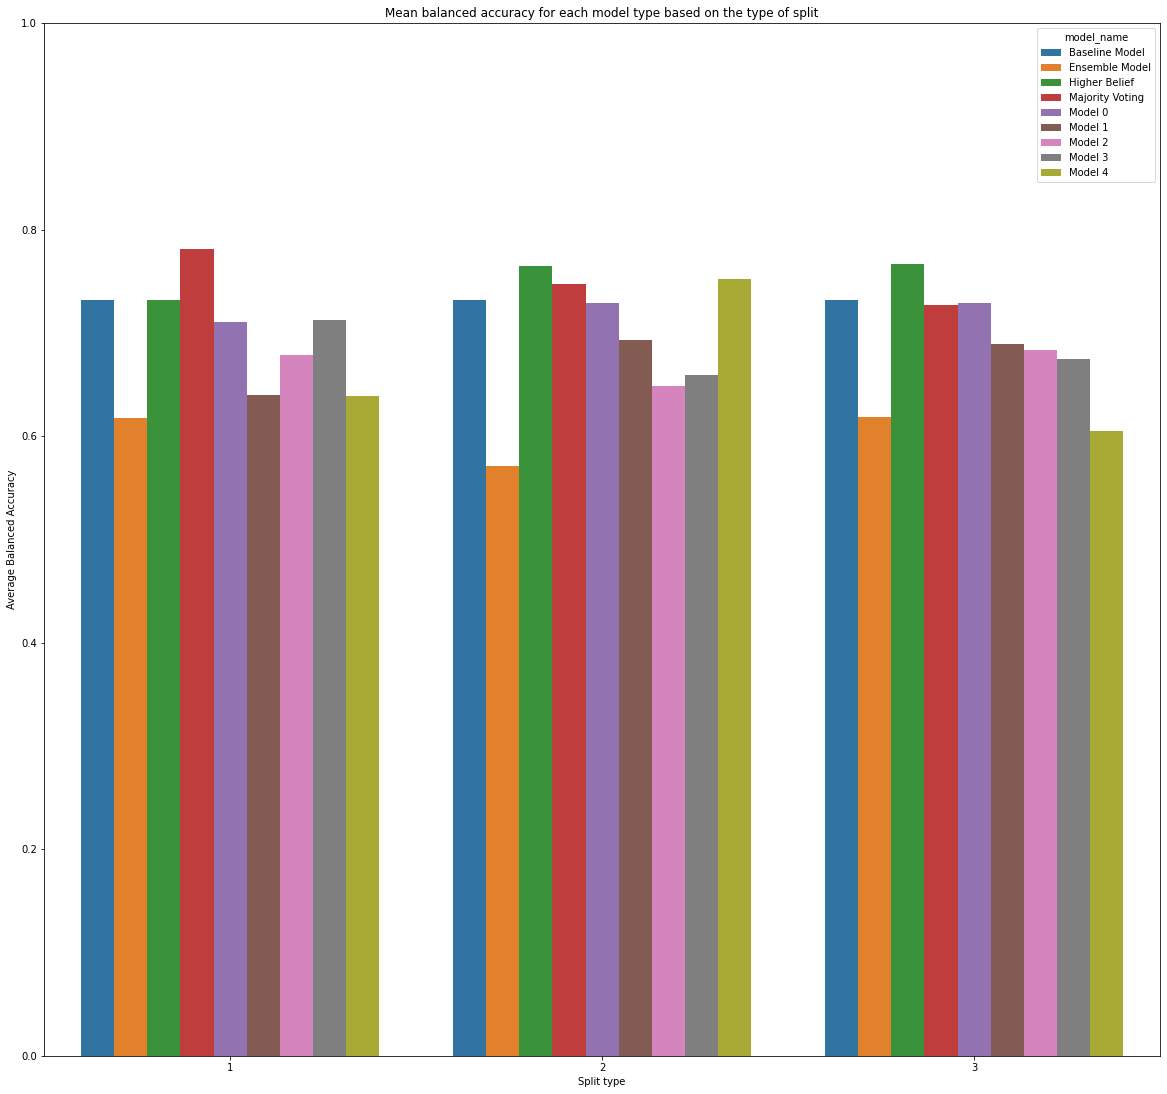

In [138]:
df = results.groupby(['model_name', 'type_split']).mean().reset_index()
plt.figure(figsize=(20, 19))
sns.barplot(data=df, x='type_split', y='balanced_accuracy', hue='model_name')
plt.title('Mean balanced accuracy for each model type based on the type of split')
plt.xlabel('Split type')
plt.ylim(0, 1)
plt.ylabel('Average Balanced Accuracy')
plt.savefig(f'{name}_type_split.png')

In [139]:
results.groupby(['model_name', 'num_estimators', 'type_split']).mean()

fold  balanced_accuracy        f1
model_name      num_estimators type_split                                  
Baseline Model  3              1           2.0           0.732067  0.762442
                               2           2.0           0.732067  0.762442
                               3           2.0           0.732067  0.762442
                5              1           2.0           0.732067  0.762442
                               2           2.0           0.732067  0.762442
                               3           2.0           0.732067  0.762442
Ensemble Model  3              1           2.0           0.735934  0.694508
                               2           2.0           0.641623  0.548861
                               3           2.0           0.678474  0.647696
                5              1           2.0           0.500000  0.220490
                               2           2.0           0.500000  0.220490
                               3           2.0           0.558434  0.339099
Higher Belief   3              1           2.0           0.745397  0.765752
                               2           2.0           0.747774  0.776743
                               3           2.0           0.733997  0.764001
                5              1           2.0           0.717652  0.705869
                               2           2.0           0.781111  0.803109
                               3           2.0           0.798651  0.818292
Majority Voting 3              1           2.0           0.780234  0.799073
                               2           2.0           0.741425  0.770609
                               3           2.0           0.734131  0.763785
                5              1           2.0           0.781172  0.753466
                               2           2.0           0.753023  0.773515
                               3           2.0           0.720155  0.675910
Model 0         3              1           2.0           0.732673  0.740876
                               2           2.0           0.678535  0.645975
                               3           2.0           0.742330  0.768096
                5              1           2.0           0.687976  0.635460
                               2           2.0           0.778824  0.796891
                               3           2.0           0.715559  0.681554
Model 1         3              1           2.0           0.643831  0.587178
                               2           2.0           0.730090  0.760239
                               3           2.0           0.675552  0.645295
                5              1           2.0           0.635325  0.529521
                               2           2.0           0.655992  0.558803
                               3           2.0           0.702774  0.664266
Model 2         3              1           2.0           0.760335  0.788130
                               2           2.0           0.692882  0.660898
                               3           2.0           0.735916  0.764822
                5              1           2.0           0.597211  0.438358
                               2           2.0           0.604762  0.450845
                               3           2.0           0.630970  0.535546
Model 3         5              1           2.0           0.712547  0.709812
                               2           2.0           0.659242  0.623727
                               3           2.0           0.675007  0.638601
Model 4         5              1           2.0           0.639278  0.471804
                               2           2.0           0.752017  0.778045
                               3           2.0           0.604895  0.448209

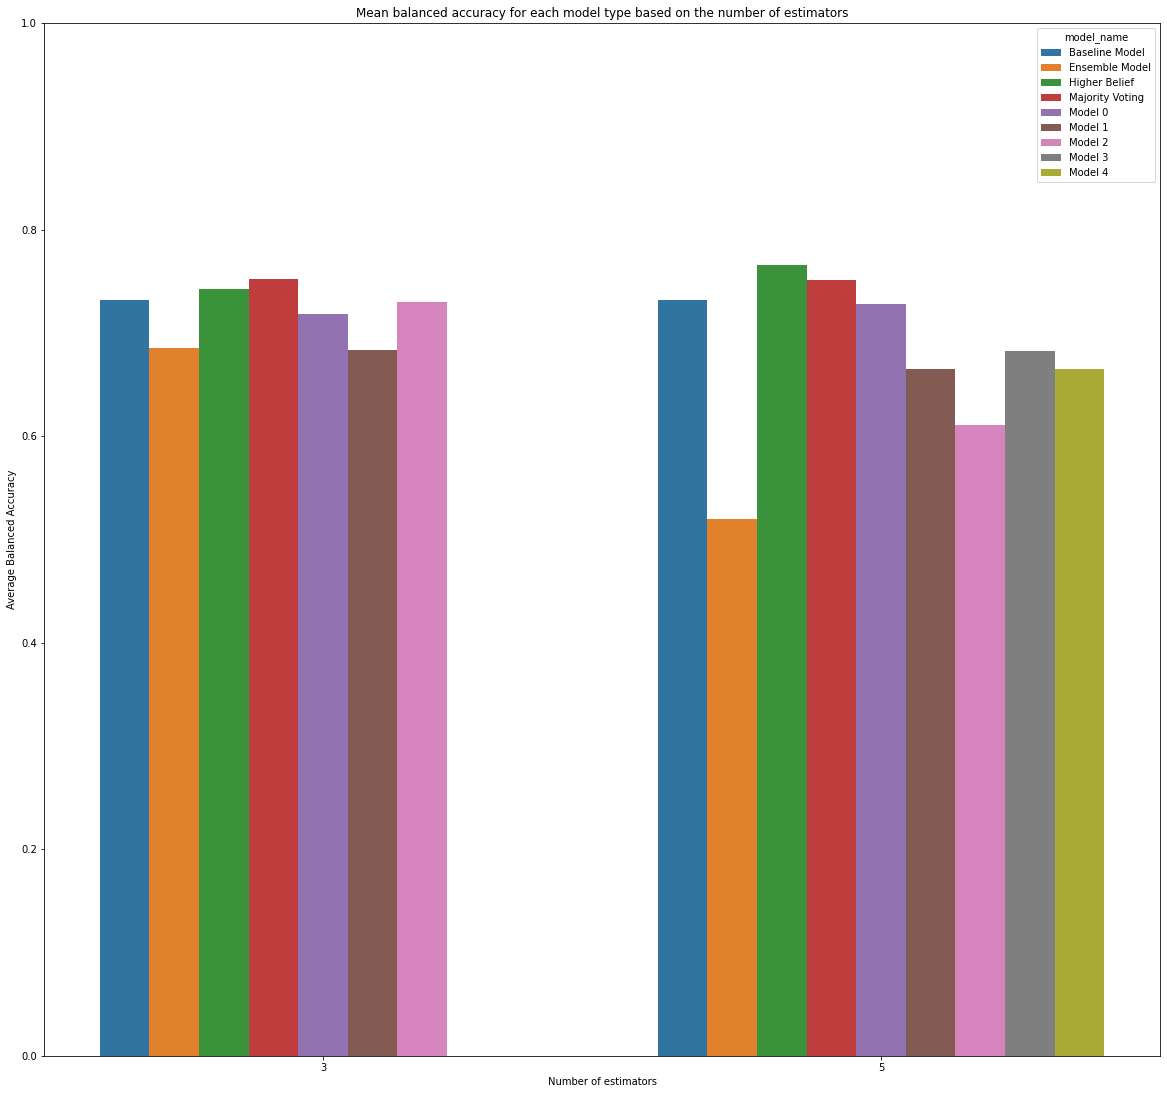

In [140]:
df = results.groupby(['model_name', 'num_estimators']).mean().reset_index()
plt.figure(figsize=(20, 19))
sns.barplot(data=df, x='num_estimators', y='balanced_accuracy', hue='model_name')
plt.title('Mean balanced accuracy for each model type based on the number of estimators')
plt.xlabel('Number of estimators')
plt.ylim(0, 1)
plt.ylabel('Average Balanced Accuracy')
plt.savefig(f'{name}_n_estimators.png')

In [141]:
results.to_csv(f'{name}-results.csv', index=False)